In [1]:
import pyproj
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import json
from datetime import datetime, timedelta

# Projektionsdefinitionen
lv95 = pyproj.Proj(init='epsg:2056')
wgs84 = pyproj.Proj(init='epsg:4326')

# Funktion zur Konvertierung von LV95 nach WGS84
def lv95_to_wgs84(point):
    x_lv95, y_lv95 = point.x, point.y
    x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
    return Point(x_wgs84, y_wgs84)

# Funktion zum Laden des Straßennetzwerks
def load_street_network(north, south, east, west):
    return ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

# Funktion zum Speichern des Straßennetzwerks als GeoPackage
def save_street_network(G, filepath):
    ox.io.save_graph_geopackage(G, filepath)

# Funktion zum Hinzufügen der Rückfahrt-Haltestellen
def add_return_trip(bus_stops):
    return_trip_stops = bus_stops.iloc[:-1].iloc[::-1]
    return pd.concat([bus_stops, return_trip_stops], ignore_index=True)

# Funktion zur Bestimmung des nächsten Netzwerkknotens zu einem Punkt
def get_nearest_node(G, point):
    return ox.distance.nearest_nodes(G, point.x, point.y)

# Funktion zum Berechnen des kürzesten Pfads zwischen den Haltestellen
def compute_shortest_paths_alt(G, points_gdf):
    routes = []
    route_lengths = []
    for idx, row in points_gdf.iterrows():
        orig = get_nearest_node(G, row['geometry'])
        next_row = points_gdf.iloc[(idx + 1) % len(points_gdf)]
        dest = get_nearest_node(G, next_row['geometry'])
        route = ox.shortest_path(G, orig, dest, weight="length")
        routes.append(route)
        route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
        route_lengths.append(route_length)
    return routes, route_lengths


def load_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def passengers_on_bus(bus_stops_gdf, demand_geojson, destination_geojson):
    passengers = []
    bus_stop_coords = [(point.x, point.y) for point in bus_stops_gdf.geometry]

    for demand_feature, dest_feature in zip(demand_geojson['features'], destination_geojson['features']):
        passenger_origin = Point(demand_feature['geometry']['coordinates'])
        passenger_destination = Point(dest_feature['geometry']['coordinates'])

        origin_in_buffer = False
        destination_in_buffer = False
        for coord in bus_stop_coords:
            bus_stop_point = Point(coord)
            if bus_stop_point.buffer(500).contains(passenger_origin):
                origin_in_buffer = True
                start = bus_stop_point
            if bus_stop_point.buffer(500).contains(passenger_destination):
                destination_in_buffer = True
                end = bus_stop_point
            if origin_in_buffer and destination_in_buffer:
                passengers.append({
                    'origin': passenger_origin,
                    'destination': passenger_destination,
                    'start': start,
                    'end': end,
                    'timestamp': demand_feature['properties']['timestamp']
                })
                break

    passengers_gdf = gpd.GeoDataFrame(passengers, geometry='origin')
    return passengers_gdf

def plot_passengers(passengers_gdf, bus_stops_gdf, demand_geojson, destination_geojson, gemeindegrenzen):
    fig, ax = plt.subplots(figsize=(10, 8))

    bus_stops_gdf.plot(ax=ax, color='grey', markersize=30, label='Bus Stops')

    for feature in demand_geojson['features']:
        point = Point(feature['geometry']['coordinates'])
        ax.plot(point.x, point.y, 'go', markersize=6)

    for feature in destination_geojson['features']:
        point = Point(feature['geometry']['coordinates'])
        ax.plot(point.x, point.y, 'bo', markersize=6)

    origin_gdf = passengers_gdf[['origin', 'timestamp']].copy()
    destination_gdf = gpd.GeoDataFrame()
    destination_gdf['destination'] = None
    destination_gdf['geometry'] = passengers_gdf['destination'].apply(Point)
    destination_gdf = gpd.GeoDataFrame(destination_gdf)
    destination_gdf.set_geometry('geometry', inplace=True)

    origin_gdf.plot(ax=ax, color='orange', markersize=20, label='Origin Points', zorder=2)
    destination_gdf.plot(ax=ax, color='yellow', markersize=20, label='Destination Points', zorder=2)

    gemeindegrenzen.plot(ax=ax, color='black', alpha=0.5, label='Shapefile')

    ax.set_title('Bus Stops, Demand and Destination Points, and Passengers')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    demand_legend = plt.Line2D([], [], color='green', marker='o', markersize=8, linestyle='None', label='Demand Points')
    destination_legend = plt.Line2D([], [], color='blue', marker='o', markersize=8, linestyle='None', label='Destination Points')
    passengers_demand_legend = plt.Line2D([], [], color='orange', marker='o', markersize=8, linestyle='None', label='Passengers origin')
    passengers_destination_legend = plt.Line2D([], [], color='yellow', marker='o', markersize=8, linestyle='None', label='Passengers destination')

    ax.legend(handles=[demand_legend, destination_legend, passengers_demand_legend, passengers_destination_legend], loc='upper left')

    plt.show()

def count_passengers(passengers_gdf):
    num_passengers = passengers_gdf.shape[0]
    return num_passengers
    print("Anzahl der Passagiere im Bus:", num_passengers)

# Funktion zum Plotten der Routen auf dem Straßennetzwerk
def plot_routes(G, routes):
    fig, ax = ox.plot_graph_routes(G, routes, node_size=0)
    plt.show()


c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox



# Liste der Farben für die Gemeinden
farben = {
    'Meilen': 'blue',
    'Egg': 'green',
    'Uster': 'red',
    'Uetikon am See': 'orange'
}
def plot_points(ax, punkt, farbe, label):
    ax.scatter(punkt.x, punkt.y, color=farbe, label=label)

def plot_demand_distribution(gemeindengrenzen_gdf, gemeinden_zentral_gdfs,
                             gemeinden_höhere_Dichte_gdfs, gemeinden_niedrige_Dichte_gdfs,
                             strassennetz_gdf, alle_punkte):

    fig, ax = plt.subplots(figsize=(10, 10))
    gemeindengrenzen_gdf.plot(ax=ax, color='black', edgecolor='black', alpha=0.5, label='Gemeindengrenzen')
    gemeinden_zentral_gdfs.plot(ax=ax, color='orange', edgecolor='gray', alpha=0.5, label='Zentral')
    gemeinden_höhere_Dichte_gdfs.plot(ax=ax, color='lightblue', edgecolor='gray', alpha=0.5, label='Höhere Dichte')
    gemeinden_niedrige_Dichte_gdfs.plot(ax=ax, color='lightgreen', edgecolor='gray', alpha=0.5, label='Niedrige Dichte')

    strassennetz_gdf.plot(ax=ax, color='gray', alpha=0.5, label='Straßennetz')
    plt.title('Verteilung der Nachfragepunkte in den Zonen')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    legend_labels = set()

    for index, row in alle_punkte.iterrows():
        punkt = row.geometry
        gemeinde = row.gemeinde
        if gemeinde not in legend_labels:
            plot_points(ax, punkt, farben[gemeinde], gemeinde)
            legend_labels.add(gemeinde)
        else:
            plot_points(ax, punkt, farben[gemeinde], None)

    ax.set_xlim([strassennetz_gdf.total_bounds[0], strassennetz_gdf.total_bounds[2]])
    ax.set_ylim([strassennetz_gdf.total_bounds[1], strassennetz_gdf.total_bounds[3]])
    ax.legend(title='Legende', loc='upper left')  # Legende außerhalb der Schleife platzieren

    plt.show()


def plot_routes(G, routes):
    fig, ax = ox.plot_graph_routes(G, routes, node_size=0)
    return fig, ax

C:\Users\Linus\AppData\Local\Temp\ipykernel_1540\2511103436.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_1540\2511103436.py:48: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_1540\2511103436.py:48: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_1540\2511103436.py:48: UserWarning: The `get_route_edge_attributes` func

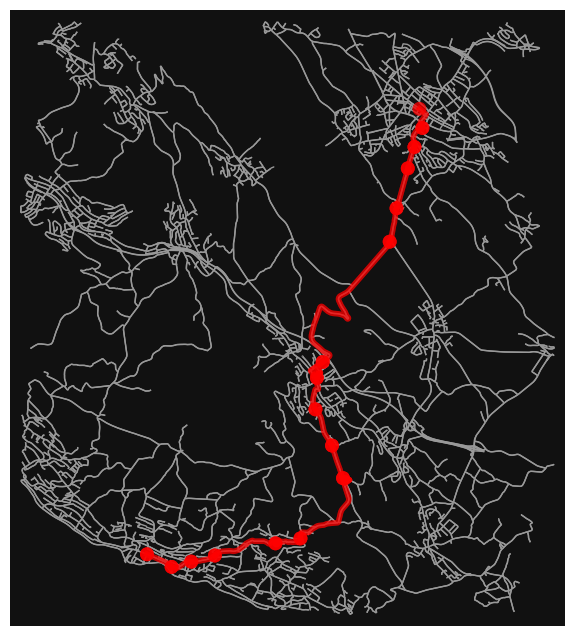

    id                         name              geometry
0    1              Meilen, Bahnhof  POINT (8.644 47.269)
1    2               Meilen, Beugen  POINT (8.651 47.267)
2    3            Meilen, Schulhaus  POINT (8.657 47.268)
3    4             Meilen, Aebleten  POINT (8.663 47.269)
4    5     Uetikon am See, Rundiweg  POINT (8.678 47.272)
5    6     Uetikon am See, Bergheim  POINT (8.686 47.272)
6    7         Egg, Ausser-Vollikon  POINT (8.697 47.283)
7    8          Egg, Inner-Vollikon  POINT (8.694 47.289)
8    9             Egg, Rainstrasse  POINT (8.690 47.296)
9   10               Egg, Forchbahn  POINT (8.690 47.301)
10  11               Egg, Industrie  POINT (8.692 47.305)
11  12  Riedikon, Chis/Naturstation  POINT (8.710 47.326)
12  13               Riedikon, Dorf  POINT (8.711 47.332)
13  14             Uster, Im Hölzli  POINT (8.714 47.339)
14  15              Uster, Talacker  POINT (8.716 47.343)
15  16        Uster, Zentralstrasse  POINT (8.718 47.347)
16  17        

ValueError: Unknown column origin

In [4]:

ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_DOCS = 'src/main/resources/Dokumente/'
ROOT_Busstations = 'src/main/resources/Buslinie/Busstationen/'

# Lade und die Gemeindegrenzen
shp_file = ROOT_FILES + 'src/main/resources/QGIS/Gemeindegrenzen/Grenzen_komp.shp'
gemeindegrenzen = gpd.read_file(shp_file)

# Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'

# Definieren des Bereichs für das Straßennetzwerk
north, south, east, west = 47.3667, 47.2586, 8.754, 8.6103

# Laden des Straßennetzwerks
G = load_street_network(north, south, east, west)

# Füge Geschwindigkeit zu den Kanten des Graphen hinzu (benötigt für die travel_time-Berechnung)
G = ox.add_edge_speeds(G)

# Berechne die Reisezeit (travel_time) in Sekunden basierend auf der Geschwindigkeit
G = ox.add_edge_travel_times(G)

# Berechne die Reisezeit (travel_time) in Sekunden basierend auf der Geschwindigkeit
G = ox.add_edge_travel_times(ox.add_edge_speeds(G))

# Speichern des Straßennetzwerks als GeoPackage
save_street_network(G, ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "OSMStrassennetz.gpkg")

#Bestimme Abfahrtszeit der Busse
start_timestamp = pd.Timestamp('2018-04-20 09:05:00')

# Laden der Bushaltestellen
bus_stops = gpd.read_file(ROOT_FILES + ROOT_Busstations + "Bushalte.shp")

# Hinzufügen der Rückfahrt-Haltestellen
bus_stops_with_return = add_return_trip(bus_stops)

# Konvertierung der Bushaltestellenprojektion von LV95 nach WGS84
bus_stops_with_return_wgs84 = bus_stops_with_return.copy()
bus_stops_with_return_wgs84['geometry'] = bus_stops_with_return_wgs84['geometry'].apply(lv95_to_wgs84)
#print(bus_stops_with_return_wgs84)

# Berechnung der kürzesten Routen zwischen den Haltestellen
routes, route_lengths = compute_shortest_paths_alt(G, bus_stops_with_return_wgs84)
#routes, route_lengths, busstops_with_timetable_gdf = compute_shortest_paths(G, bus_stops_with_return_wgs84, start_timestamp)
#print(busstops_with_timetable_gdf)

# Plotten der Routen auf dem Straßennetzwerk
plot_routes(G, routes)

file_path_demand = ROOT_FILES + ROOT_DOCS + "Nachfrage_bahnhof.geojson"
file_path_destination = ROOT_FILES + ROOT_DOCS + "Ziele_bahnhof.geojson"
demand_geojson = load_geojson(file_path_demand)
destination_geojson = load_geojson(file_path_destination)

print(bus_stops_with_return_wgs84)
passengers_gdf = passengers_on_bus(bus_stops_with_return_wgs84, demand_geojson, destination_geojson)
#print(passengers_gdf)
#print(passengers_gdf.head())

#plot_passengers(passengers_gdf, bus_stops_with_return, demand_geojson, destination_geojson, gemeindegrenzen)

# Berechnung der Gesamtlänge der Route
total_route_length = sum(route_lengths) / 1000
print("Gesamtlänge der Route:", total_route_length, "Kilometer")
# Gib die Anzahl Passagiere zurück
num_passengers = count_passengers(passengers_gdf)
print("Anzahl der Passagiere im Bus:", num_passengers)
travel_time_bus = 55



In [ ]:
from datetime import datetime, timedelta
def compute_shortest_paths(G, points_gdf, start_time):
    routes = []
    route_lengths = []
    ankunftszeiten = []

    # Startzeit als datetime-Objekt parsen
    aktuelle_zeit = start_time
    ankunftszeiten.append(aktuelle_zeit)
    v = 12  # Geschwindigkeit in m/s

    for idx, row in points_gdf.iterrows():
        orig = get_nearest_node(G, row['geometry'])
        next_idx = (idx + 1) % len(points_gdf)
        next_row = points_gdf.iloc[next_idx]
        dest = get_nearest_node(G, next_row['geometry'])

        # Berechne die Fahrzeit für die aktuelle Route
        route = ox.shortest_path(G, orig, dest, weight="length")
        routes.append(route)
        route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
        route_lengths.append(route_length)

        # Berechne die Reisezeit in Sekunden
        route_travel_time = route_length / v
        aktuelle_zeit += timedelta(seconds=route_travel_time)
        ankunftszeiten.append(aktuelle_zeit)

        # Füge eine 10-minütige Pause in der Hälfte der Stopps ein
        if (idx + 1) % (len(points_gdf) // 2) == 0:
            aktuelle_zeit += timedelta(minutes=5)

    # Füge die Ankunftszeiten als neue Spalte zur GeoDataFrame hinzu
    points_gdf['ankunftszeit'] = ankunftszeiten[:-1]  # Letzte Zeit ist für den nächsten Startpunkt

    return routes, route_lengths, points_gdf




C:\Users\Linus\AppData\Local\Temp\ipykernel_16824\2511103436.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_16824\1997651011.py:21: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_16824\1997651011.py:21: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
C:\Users\Linus\AppData\Local\Temp\ipykernel_16824\1997651011.py:21: UserWarning: The `get_route_edge_attributes` 

    id                         name              geometry  \
0    1              Meilen, Bahnhof  POINT (8.644 47.269)   
1    2               Meilen, Beugen  POINT (8.651 47.267)   
2    3            Meilen, Schulhaus  POINT (8.657 47.268)   
3    4             Meilen, Aebleten  POINT (8.663 47.269)   
4    5     Uetikon am See, Rundiweg  POINT (8.678 47.272)   
5    6     Uetikon am See, Bergheim  POINT (8.686 47.272)   
6    7         Egg, Ausser-Vollikon  POINT (8.697 47.283)   
7    8          Egg, Inner-Vollikon  POINT (8.694 47.289)   
8    9             Egg, Rainstrasse  POINT (8.690 47.296)   
9   10               Egg, Forchbahn  POINT (8.690 47.301)   
10  11               Egg, Industrie  POINT (8.692 47.305)   
11  12  Riedikon, Chis/Naturstation  POINT (8.710 47.326)   
12  13               Riedikon, Dorf  POINT (8.711 47.332)   
13  14             Uster, Im Hölzli  POINT (8.714 47.339)   
14  15              Uster, Talacker  POINT (8.716 47.343)   
15  16        Uster, Zen

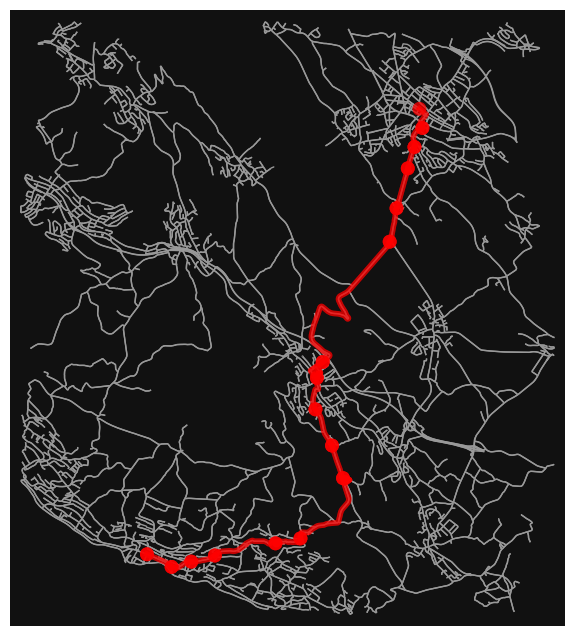

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:

ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_DOCS = 'src/main/resources/Dokumente/'
ROOT_Busstations = 'src/main/resources/Buslinie/Busstationen/'

# Lade und die Gemeindegrenzen
shp_file = ROOT_FILES + 'src/main/resources/QGIS/Gemeindegrenzen/Grenzen_komp.shp'
gemeindegrenzen = gpd.read_file(shp_file)

# Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'

# Definieren des Bereichs für das Straßennetzwerk
north, south, east, west = 47.3667, 47.2586, 8.754, 8.6103

# Laden des Straßennetzwerks
G = load_street_network(north, south, east, west)

# Füge Geschwindigkeit zu den Kanten des Graphen hinzu (benötigt für die travel_time-Berechnung)
G = ox.add_edge_speeds(G)

# Berechne die Reisezeit (travel_time) in Sekunden basierend auf der Geschwindigkeit
G = ox.add_edge_travel_times(G)

# Berechne die Reisezeit (travel_time) in Sekunden basierend auf der Geschwindigkeit
G = ox.add_edge_travel_times(ox.add_edge_speeds(G))

# Speichern des Straßennetzwerks als GeoPackage
save_street_network(G, ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "OSMStrassennetz.gpkg")

#Bestimme Abfahrtszeit der Busse
start_timestamp = pd.Timestamp('2018-04-20 09:05:00')

# Laden der Bushaltestellen
bus_stops = gpd.read_file(ROOT_FILES + ROOT_Busstations + "Bushalte.shp")

# Hinzufügen der Rückfahrt-Haltestellen
bus_stops_with_return = add_return_trip(bus_stops)

# Konvertierung der Bushaltestellenprojektion von LV95 nach WGS84
bus_stops_with_return_wgs84 = bus_stops_with_return.copy()
bus_stops_with_return_wgs84['geometry'] = bus_stops_with_return_wgs84['geometry'].apply(lv95_to_wgs84)
#print(bus_stops_with_return_wgs84)

# Berechnung der kürzesten Routen zwischen den Haltestellen
routes, route_lengths, busstops_with_timetable_gdf = compute_shortest_paths(G, bus_stops_with_return_wgs84, start_timestamp)
print(busstops_with_timetable_gdf)

# Plotten der Routen auf dem Straßennetzwerk
plot_routes(G, routes)





In [ ]:
print(bus_stops_with_return_wgs84)
#print(busstops_with_timetable_gdf)

    id                         name              geometry  \
0    1              Meilen, Bahnhof  POINT (8.644 47.269)   
1    2               Meilen, Beugen  POINT (8.651 47.267)   
2    3            Meilen, Schulhaus  POINT (8.657 47.268)   
3    4             Meilen, Aebleten  POINT (8.663 47.269)   
4    5     Uetikon am See, Rundiweg  POINT (8.678 47.272)   
5    6     Uetikon am See, Bergheim  POINT (8.686 47.272)   
6    7         Egg, Ausser-Vollikon  POINT (8.697 47.283)   
7    8          Egg, Inner-Vollikon  POINT (8.694 47.289)   
8    9             Egg, Rainstrasse  POINT (8.690 47.296)   
9   10               Egg, Forchbahn  POINT (8.690 47.301)   
10  11               Egg, Industrie  POINT (8.692 47.305)   
11  12  Riedikon, Chis/Naturstation  POINT (8.710 47.326)   
12  13               Riedikon, Dorf  POINT (8.711 47.332)   
13  14             Uster, Im Hölzli  POINT (8.714 47.339)   
14  15              Uster, Talacker  POINT (8.716 47.343)   
15  16        Uster, Zen

In [ ]:
def passengers_on_bus(bus_stops_gdf, demand_geojson, destination_geojson):
    passengers = []
    bus_stop_coords = [(point.x, point.y) for point in bus_stops_gdf.geometry]
    bus_stop_times = list(bus_stops_gdf['ankunftszeit'])

    for demand_feature, dest_feature in zip(demand_geojson['features'], destination_geojson['features']):
        passenger_origin = Point(demand_feature['geometry']['coordinates'])
        passenger_destination = Point(dest_feature['geometry']['coordinates'])
        passenger_time = datetime.strptime(demand_feature['properties']['timestamp'], '%Y-%m-%dT%H:%M:%S')
        #print(passenger_time)

        origin_in_buffer = False
        destination_in_buffer = False

        for coord, stop_time in zip(bus_stop_coords, bus_stop_times):
            bus_stop_point = Point(coord)
            start_buffer = stop_time - timedelta(minutes=10)
            #print('startbuffer', start_buffer)
            end_buffer = stop_time + timedelta(minutes=10)
            #print('endbuffer', end_buffer)

            if bus_stop_point.buffer(500).contains(passenger_origin) and start_buffer <= passenger_time <= end_buffer:
                origin_in_buffer = True
                start = bus_stop_point
                #start_time = stop_time

            if bus_stop_point.buffer(500).contains(passenger_destination) and start_buffer <= passenger_time <= end_buffer:
                destination_in_buffer = True
                end = bus_stop_point
                #end_time = stop_time

            if origin_in_buffer and destination_in_buffer:
                #print('origin:', passenger_origin)
                passengers.append({
                    'origin': passenger_origin,
                    'destination': passenger_destination,
                    'start': start,
                    'end': end,
                    #'start_time': start_time,
                    #'end_time': end_time,
                    'timestamp': passenger_time
                })
                print(passenger_origin)
                break
    print(passengers)
    passengers_gdf = gpd.GeoDataFrame(passengers, geometry='origin')
    return passengers_gdf


In [ ]:
def passengers_on_bus(bus_stops_gdf, demand_geojson, destination_geojson):
    passengers = []
    bus_stop_coords = [(point.x, point.y) for point in bus_stops_gdf.geometry]

    for demand_feature, dest_feature in zip(demand_geojson['features'], destination_geojson['features']):
        passenger_origin = Point(demand_feature['geometry']['coordinates'])
        passenger_destination = Point(dest_feature['geometry']['coordinates'])

        origin_in_buffer = False
        destination_in_buffer = False
        for coord in bus_stop_coords:
            bus_stop_point = Point(coord)
            if bus_stop_point.buffer(500).contains(passenger_origin):
                origin_in_buffer = True
                start = bus_stop_point
            if bus_stop_point.buffer(500).contains(passenger_destination):
                destination_in_buffer = True
                end = bus_stop_point
            if origin_in_buffer and destination_in_buffer:
                passengers.append({
                    'origin': passenger_origin,
                    'destination': passenger_destination,
                    'start': start,
                    'end': end,
                    'timestamp': demand_feature['properties']['timestamp']
                })
                break

    passengers_gdf = gpd.GeoDataFrame(passengers, geometry='origin')
    return passengers_gdf

In [ ]:
file_path_demand = ROOT_FILES + ROOT_DOCS + "Nachfrage.geojson"
file_path_destination = ROOT_FILES + ROOT_DOCS + "Ziele.geojson"
demand_geojson = load_geojson(file_path_demand)
destination_geojson = load_geojson(file_path_destination)

passengers_gdf = passengers_on_bus(busstops_with_timetable_gdf, demand_geojson, destination_geojson)
#print(passengers_gdf)
#print(passengers_gdf.head())

#plot_passengers(passengers_gdf, bus_stops_with_return, demand_geojson, destination_geojson, gemeindegrenzen)

# Berechnung der Gesamtlänge der Route
total_route_length = sum(route_lengths) / 1000
print("Gesamtlänge der Route:", total_route_length, "Kilometer")
# Gib die Anzahl Passagiere zurück
num_passengers = count_passengers(passengers_gdf)
print("Anzahl der Passagiere im Bus:", num_passengers)
travel_time_bus = 55

ValueError: Unknown column origin

In [ ]:
print(routes)

[[66861087, 262594280, 335539182], [335539182, 34095673, 218289611, 34095662, 216510485, 335482039, 35830593, 218307467], [218307467, 216508839, 218304990], [218304990, 2303493391, 28106266, 2504875221, 2504875390, 2349162325, 2349162339, 2349162328, 34095620, 227531247, 227531502], [227531502, 227531247, 34095620, 463218029, 28105688], [28105688, 28105552, 463218498, 413002526, 28105334, 240268801, 463218829, 28105093, 28104872, 28104877, 28104861, 10307592895], [10307592895, 28104861, 28104877, 28104872, 120393579], [120393579, 225061965, 216297840, 274103688, 469835796, 120393573], [120393573, 7555510252, 120393570, 216292600, 1493171026, 264890212, 1509996838, 264890214, 216282009, 4083586928, 216282586, 216283486, 393962506], [393962506, 216283486, 216282586, 4083586928, 4083586933, 469833806, 469833850, 1880125007], [1880125007, 291902375, 291902959, 291902370, 35831193, 2459192571, 1599382891, 233039815, 265155506, 27505281, 27505280, 35831539], [35831539, 27505267, 1479539363, 

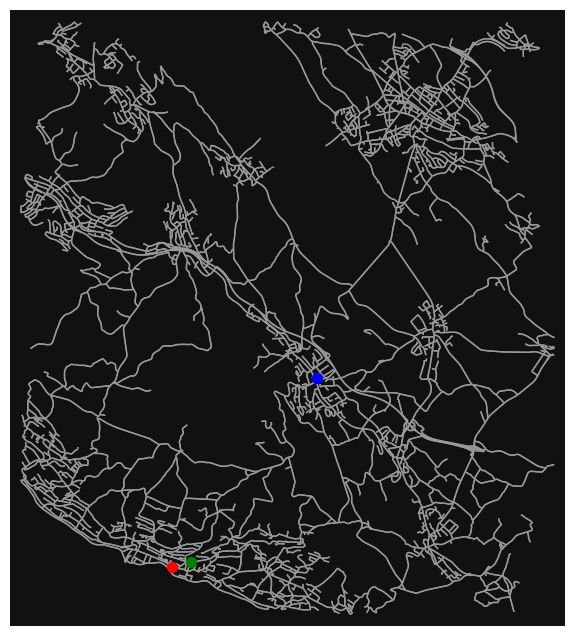

Route von 335539182 nach 218307467 ist 445.26800000000003 lang
Route von 335539182 nach 218307467 dauert 0.1 Minuten


C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4067803331.py:28: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))


In [ ]:
def plot_nodes_on_graph(G, nodes_list, colors):
    """
    Plots the specified nodes on the graph with different colors.
    
    Parameters:
        - G (networkx.MultiDiGraph): The street network graph.
        - nodes_list (list): List of manual node IDs.
        - colors (list): List of colors corresponding to each node.
    """
    # Plot des Straßennetzwerks ohne Node-Größe
    fig, ax = ox.plot_graph(G, node_size=0, show=False)
    
    # Markiere die manuellen Nodes mit unterschiedlichen Farben
    for node_id, color in zip(nodes_list, colors):
        node_position = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
        ax.scatter(*node_position, color=color, s=50, zorder=5)
    
    # Anzeigen des Plots
    plt.show()

# Beispielaufruf der Funktion mit einer Liste von manuellen Nodes und Farben
manual_nodes_list = [335539182, 218307467, 393962506]
node_colors = ['red', 'green', 'blue']  # Beispielhafte Farben für die Punkte
plot_nodes_on_graph(G, manual_nodes_list, node_colors)

orig, dest = 335539182, 218307467
route = ox.shortest_path(G, orig, dest, weight="length")
route_length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
route_travel_time = nx.shortest_path_length(G, orig, dest, weight='travel_time') / 60
        
print(f"Route von {orig} nach {dest} ist {route_length} lang")
print(f"Route von {orig} nach {dest} dauert {route_travel_time} Minuten")

In [ ]:
def compute_shortest_paths_travel_time(G, passengers_gdf):
    #routes = []
    route_travel_times = []
    
    for idx, row in passengers_gdf.iterrows():
        orig = get_nearest_node(G, lv95_to_wgs84(row['start']))
        dest = get_nearest_node(G, lv95_to_wgs84(row['end']))
        
        # Berechne die Reisezeit für den kürzesten Pfad
        route_travel_time = nx.shortest_path_length(G, orig, dest, weight='travel_time')
        route_travel_times.append(route_travel_time)
        print("Reisezeit von", orig, "nach", dest, ":", route_travel_time, "Minuten")
    
    # Füge die Spalte 'travel_time' mit den berechneten Reisezeiten zum DataFrame hinzu
    passengers_gdf['travel_time'] = route_travel_times
    
    return passengers_gdf

passengers_gdf = compute_shortest_paths_travel_time(G, passengers_gdf)
print(passengers_gdf['travel_time'])


Reisezeit von 120393573 nach 218307467 : 22 Minuten


C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-py

Reisezeit von 393962506 nach 218304990 : 33 Minuten
Reisezeit von 120393573 nach 218307467 : 22 Minuten
Reisezeit von 6459535455 nach 120393579 : 36 Minuten
Reisezeit von 66861087 nach 227531502 : 19 Minuten


C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-py

Reisezeit von 335539182 nach 393962506 : 33 Minuten
Reisezeit von 66861087 nach 120393573 : 29 Minuten
Reisezeit von 227531502 nach 218307467 : 12 Minuten
0    22
1    33
2    22
3    36
4    19
5    33
6    29
7    12
Name: travel_time, dtype: int64


C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4420\4041161130.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-py

In [ ]:
# Berechne die Travel Time von jedem Passagier
def calculate_travel_time(passengers_gdf, routes):
    travel_time_passenger = travel_time_bus / num_passengers
    return travel_time_passenger

In [ ]:
print("Anzahl der Passagiere im Bus:", passengers)
print("Gesamtlänge der Route:", route_length, "Kilometer")
print("Reisezeit des Busses:", travel_time, "Minuten")

NameError: name 'passengers' is not defined